In [48]:
# 1. Імпорти
# Стандартні
import numpy as np
import pandas as pd

# Візуалізація
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [49]:
# 2. Завантаження даних
df_raw = pd.read_csv('/Users/sergiymendrik/Desktop/ІТ/ML Projects/Titanic - Machine Learning from Disaster/train.csv')


In [50]:
# 3. Первинний огляд
df_raw.shape
df_raw.columns
df_raw.info()
df_raw.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [51]:
# 4. Предобробка
def preprocess_data(df):
    df = df.copy()
    
    # Базове очищення
    df.drop(columns=['Cabin','Ticket'],errors = 'ignore', inplace = True)
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    # Кодування статті
    df['Sex'] = df['Sex'].map({'male':0,'female':1})
    
    # Створення нових ознак
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Витяг заголовку з імені
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.',expand = False)
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace(['Mme'],'Mrs')
    df['Title'] = df['Title'].replace(['Dr','Major','Col','Rev','Capt','Don','Sir','Countess','Lady','Jonkheer'],'Rare')
    
    # Кодування категорій 
    df = pd.get_dummies(df,columns=['Embarked','Title'],drop_first=True)
    
    # Видаляємо непотрібні
    df.drop(columns=['PassengerId','Name'],errors='ignore',inplace=True)
    
    return df


In [52]:
# 5. Побудова моделі
def train_and_evaluate(df):
    df_processed = preprocess_data(df)
    X = df_processed.drop('Survived',axis=1)
    y = df_processed['Survived']
    
    X_train,X_test,y_train,y_test = train_test_split(
        X,y, test_size=0.2,random_state=42,stratify=y
    )
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test,y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test,y_pred))
    print("Classification report:\n", classification_report(y_test,y_pred))
    
    # 6. Оцінка моделі - графік матриці плутанини
    cm= confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


    return df_processed, X_train, X_test, y_train, y_test, model, y_pred

Accuracy: 0.8212290502793296
Confusion matrix:
 [[98 12]
 [20 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



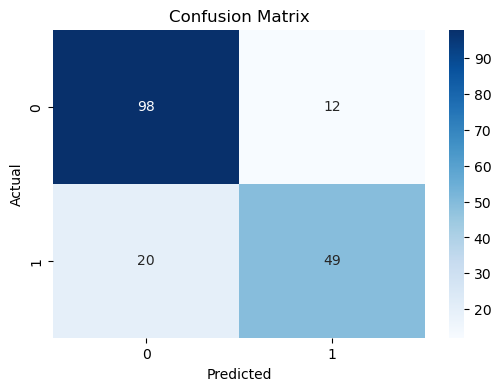

In [53]:
df_processed, X_train, X_test, y_train, y_test, model, y_pred = train_and_evaluate(df_raw)

Accuracy: 0.8212290502793296
Confusion matrix:
 [[98 12]
 [20 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



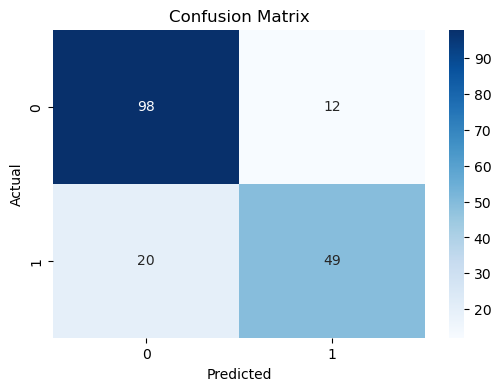

(     Survived  Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  IsAlone  \
 0           0       3    0  22.0      1      0   7.2500           2        0   
 1           1       1    1  38.0      1      0  71.2833           2        0   
 2           1       3    1  26.0      0      0   7.9250           1        1   
 3           1       1    1  35.0      1      0  53.1000           2        0   
 4           0       3    0  35.0      0      0   8.0500           1        1   
 ..        ...     ...  ...   ...    ...    ...      ...         ...      ...   
 886         0       2    0  27.0      0      0  13.0000           1        1   
 887         1       1    1  19.0      0      0  30.0000           1        1   
 888         0       3    1  28.0      1      2  23.4500           4        0   
 889         1       1    0  26.0      0      0  30.0000           1        1   
 890         0       3    0  32.0      0      0   7.7500           1        1   
 
      Embarked_Q  Embarked

In [54]:
train_and_evaluate(df_raw)


In [55]:
# 7. Крос-валідація
def cross_validation(df, cv=5):
    df_processed = preprocess_data(df)
    X = df_processed.drop('Survived',axis=1)
    y = df_processed['Survived']
    
    model = LogisticRegression(max_iter=1000)
    scores = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    
    print(f"Кросс валідація ({cv}-fold):")
    print(f"Accuracy для кожної ітерації :", scores)
    for i , score in enumerate(scores,1):
            print(f" -Fold {i}: {score:.4f}")
    print(f"Середнє Accuracy: {scores.mean():.4f}")
    print(f"Стандартне відхилення: {scores.std():.4f}")


In [56]:
cross_validation(df_raw,cv=5)


Кросс валідація (5-fold):
Accuracy для кожної ітерації : [0.82122905 0.80898876 0.80337079 0.79775281 0.85393258]
 -Fold 1: 0.8212
 -Fold 2: 0.8090
 -Fold 3: 0.8034
 -Fold 4: 0.7978
 -Fold 5: 0.8539
Середнє Accuracy: 0.8171
Стандартне відхилення: 0.0200


In [57]:
# 8. Підбір параметрів
def grid_search_logreg(df):
    df_processed = preprocess_data(df)
    X = df_processed.drop('Survived',axis=1)
    y = df_processed['Survived']
    
    param_grid = {
        'C':[0.01,0.1,1,10,100],
        'penalty':['l2'],
        'solver':['liblinear','lbfgs']
    }
    
    model = LogisticRegression(max_iter=5000)
    grid = GridSearchCV(model,param_grid,cv=5,scoring='accuracy')
    grid.fit(X,y)
    print(f"Найкращі параметри:", grid.best_params_)    
    print(f"Найкращий accuracy: {grid.best_score_:.4f}")


Найкращі параметри: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Найкращий accuracy: 0.8238
Accuracy: 0.8212290502793296
Confusion matrix:
 [[98 12]
 [20 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



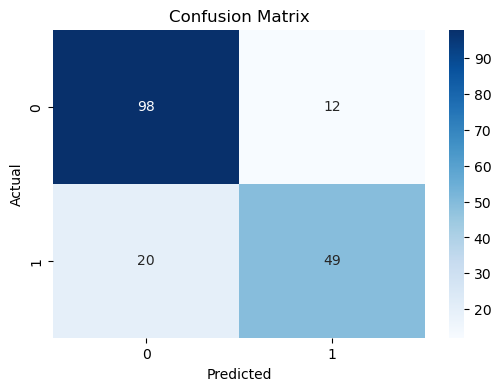

(     Survived  Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  IsAlone  \
 0           0       3    0  22.0      1      0   7.2500           2        0   
 1           1       1    1  38.0      1      0  71.2833           2        0   
 2           1       3    1  26.0      0      0   7.9250           1        1   
 3           1       1    1  35.0      1      0  53.1000           2        0   
 4           0       3    0  35.0      0      0   8.0500           1        1   
 ..        ...     ...  ...   ...    ...    ...      ...         ...      ...   
 886         0       2    0  27.0      0      0  13.0000           1        1   
 887         1       1    1  19.0      0      0  30.0000           1        1   
 888         0       3    1  28.0      1      2  23.4500           4        0   
 889         1       1    0  26.0      0      0  30.0000           1        1   
 890         0       3    0  32.0      0      0   7.7500           1        1   
 
      Embarked_Q  Embarked

In [58]:
grid_search_logreg(df_raw)
train_and_evaluate(df_raw)


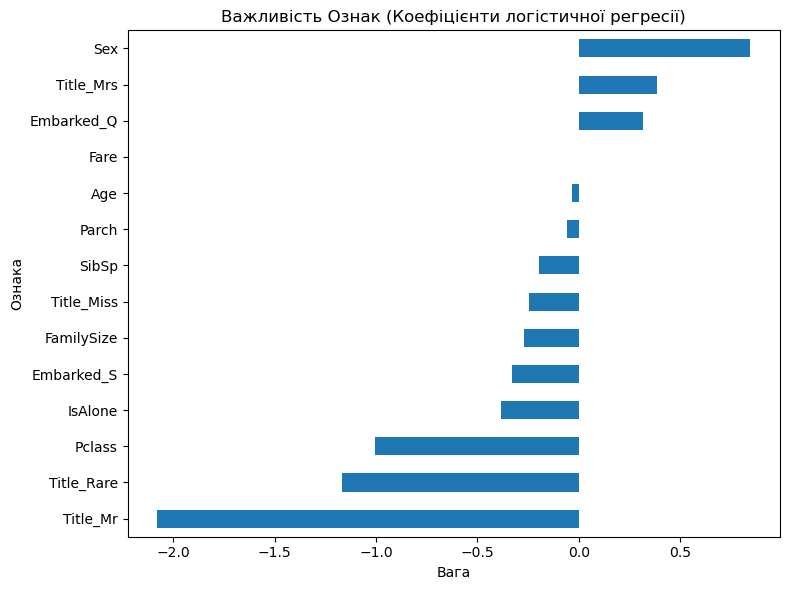

In [77]:
# Беремо ознаки
features = X_train.columns
coefficientes = model.coef_[0]

importance = pd.Series(coefficientes, index=features).sort_values()

plt.figure(figsize=(8,6))
importance.plot(kind='barh')
plt.title("Важливість Ознак (Коефіцієнти логістичної регресії)")
plt.xlabel("Вага")
plt.ylabel("Ознака")
plt.tight_layout()
plt.show()


In [81]:
features = X_train.columns
coefficients = model.coef_[0]

importance = pd.Series(coefficients, index=features).sort_values()
print(importance)

Title_Mr     -2.079675
Title_Rare   -1.166694
Pclass       -1.004425
IsAlone      -0.385108
Embarked_S   -0.330222
FamilySize   -0.272557
Title_Miss   -0.244333
SibSp        -0.197727
Parch        -0.058540
Age          -0.032395
Fare          0.003082
Embarked_Q    0.316592
Title_Mrs     0.383964
Sex           0.846833
dtype: float64


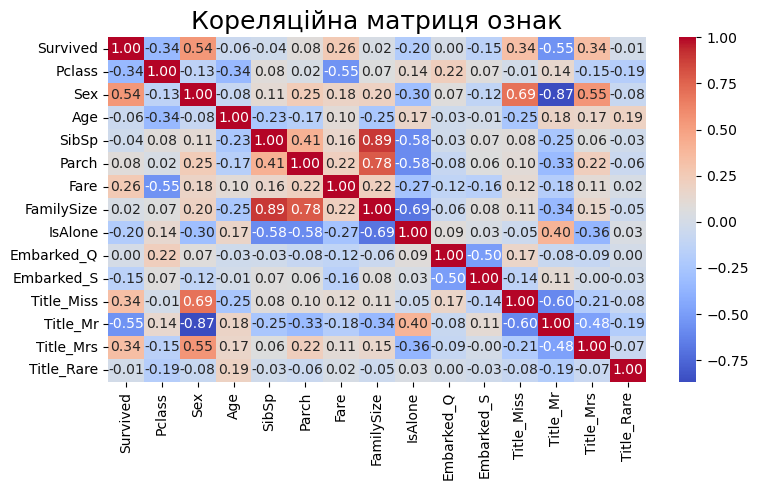

In [120]:
df_processed = preprocess_data(df_raw)
plt.figure(figsize=(8,5))
sns.heatmap(df_processed.corr(),annot=True,fmt='.2f',cmap='coolwarm',cbar=True)
plt.title("Кореляційна матриця ознак",fontsize=18)
plt.tight_layout()
plt.show()

In [121]:
corr_matrix = df_processed.corr().round(2)
corr_matrix

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
Survived,1.00,-0.34,0.54,-0.06,-0.04,0.08,0.26,0.02,-0.20,0.00,-0.15,0.34,-0.55,0.34,-0.01
Pclass,-0.34,1.00,-0.13,-0.34,0.08,0.02,-0.55,0.07,0.14,0.22,0.07,-0.01,0.14,-0.15,-0.19
Sex,0.54,-0.13,1.00,-0.08,0.11,0.25,0.18,0.20,-0.30,0.07,-0.12,0.69,-0.87,0.55,-0.08
Age,-0.06,-0.34,-0.08,1.00,-0.23,-0.17,0.10,-0.25,0.17,-0.03,-0.01,-0.25,0.18,0.17,0.19
SibSp,-0.04,0.08,0.11,-0.23,1.00,0.41,0.16,0.89,-0.58,-0.03,0.07,0.08,-0.25,0.06,-0.03
Parch,0.08,0.02,0.25,-0.17,0.41,1.00,0.22,0.78,-0.58,-0.08,0.06,0.10,-0.33,0.22,-0.06
Fare,0.26,-0.55,0.18,0.10,0.16,0.22,1.00,0.22,-0.27,-0.12,-0.16,0.12,-0.18,0.11,0.02
FamilySize,0.02,0.07,0.20,-0.25,0.89,0.78,0.22,1.00,-0.69,-0.06,0.08,0.11,-0.34,0.15,-0.05
IsAlone,-0.20,0.14,-0.30,0.17,-0.58,-0.58,-0.27,-0.69,1.00,0.09,0.03,-0.05,0.40,-0.36,0.03
Embarked_Q,0.00,0.22,0.07,-0.03,-0.03,-0.08,-0.12,-0.06,0.09,1.00,-0.50,0.17,-0.08,-0.09,0.00


In [123]:
import joblib

# зберегти модель
joblib.dump(model, 'titanic_model.joblib')

# якщо треба завантажити пізніше:
# loaded_model = joblib.load('titanic_model.joblib')
# predictions = loaded_model.predict(X_test)

['titanic_model.joblib']